In [1]:
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import math
import pandas as pd

In [2]:
# Takes a numpy array and displays the image with no axes using Matplotlib.
def display_image(image, figsize = (5, 7)):
    fig, ax = plt.subplots(1, 1, figsize = figsize)
    plt.imshow(image)
    ax.set_axis_off()
    
    return

In [3]:
# Creates a blank numpy array of the specified dimensions, with a prefilled value and encoding
def create_blank_image(resolution = (3288, 4488, 3), background_color = 34, encoding = np.uint8):
    return np.full(resolution, background_color, encoding)

In [4]:
# Draws a line on an image with openCV, using a more intuitive start_x, end_x, start_y, end_y ordering
def place_line(image, x_1, x_2, y_1, y_2, color = (255, 255, 255), line_width = 5):
    cv2.line(image, (x_1, y_1), (x_2, y_2), color, line_width)
    
    return

In [5]:
# Displays margins on an image given horizontal and vertical margin specifications
def show_margins(image, x_margin, y_margin, x_color = (0, 255, 255), y_color = (255, 255, 0)):
    # Y margins
    place_line(image, x_margin, image.shape[1] - x_margin, y_margin, y_margin, y_color)
    place_line(image, x_margin, image.shape[1] - x_margin,
               image.shape[0] - y_margin, image.shape[0] - y_margin, y_color)
    
    # # X margins
    place_line(image, x_margin, x_margin, y_margin, image.shape[0] - y_margin, x_color)
    place_line(image, image.shape[1] - x_margin, image.shape[1] - x_margin,
               y_margin, image.shape[0] - y_margin, x_color)
    
    return

In [6]:
class TextBox:
    
    def __init__(self, name, text, font, font_scale, font_width, font_color,
                 left_margin, right_margin, line_spacing,
                 paragraph_break = False, circle_size = 25, paragraph_spacing = 1.5,
                 bold_words = [], delim = ' ', splitter = ''):
        # Required attributes
        self.name = name
        self.text = text
        self.font = font
        self.font_scale = font_scale
        self.font_width = font_width
        self.font_color = font_color
        self.line_spacing = line_spacing
        self.left_margin = left_margin
        self.right_margin = right_margin
        
        # Optional attributes
        self.paragraph_break = paragraph_break
        self.circle_size = circle_size
        self.paragraph_spacing = paragraph_spacing
        self.bold_words = bold_words
        self.delim = delim
        self.splitter = splitter
        
        # Calculated attributes
        self.line_height = 0
        self.height = 0
        self.width = 0
        self.bounding_box = (0, 0)
        self.paragraphs = []

    # Calculates the bounding box as well as creates paragraphs and lines for pasting
    def calculate_text_bb(self, image, max_bb_size, min_font_scale):       
        # Generate generic size of space character to use for line height
        space_size = cv2.getTextSize(' ', self.font, self.font_scale, self.font_width)[0]
        self.line_height = space_size[1]
        # Save the original left margin to use if needed for recursion
        original_left_margin = self.left_margin

        # Shift the left margin over if there are multiple paragraphs due to bullet points
        if self.paragraph_break:
            self.left_margin = self.left_margin + self.circle_size + space_size[0]

        current_X = self.left_margin

        # Split paragraphs
        if self.paragraph_break:
            paragraphs_raw = self.text.split('\p')
        else:
            paragraphs_raw = [self.text]

        # Calculate lines for later writing to image
        paragraphs_text = []

        for paragraph_raw in paragraphs_raw:
            full_text = ''
            text_list = paragraph_raw.split(self.delim)
            current_X = self.left_margin
            
            for ix, word in enumerate(text_list):
                word = word.lstrip()
                
                # If the word is not the first, put in a leading space.
                # If the delim is not a space and the word is not the last, also add the splitter.
                if ix != 0:
                    word = ' ' + word
                if ix != len(text_list) - 1 and self.delim != ' ':
                    word += self.splitter

                # Calculate word length, then check if it goes beyond the maximum horizonal length.
                # If below maximum length, add the word and update X.
                # Else, add a newline character, remove the leading space, and update X.
                word_size = cv2.getTextSize(word, self.font, self.font_scale, self.font_width)[0]

                if (current_X + word_size[0]) <= (image.shape[1] - self.right_margin):
                    full_text += word
                    current_X += word_size[0]
                else:
                    full_text += '\n' + word[1:]           
                    current_X = self.left_margin + cv2.getTextSize(word[1:], self.font,
                                                                   self.font_scale,
                                                                   self.font_width)[0][0]

            paragraphs_text.append(full_text)

        # Create list of paragraphs containing lists of lines.
        self.paragraphs = [paragraph.split('\n') for paragraph in paragraphs_text]

        # Calculate the width and height of the paragraphs.
        for i, paragraph in enumerate(self.paragraphs):
            if i != 0:
                self.height += int(space_size[1] * (self.paragraph_spacing * self.line_spacing))

            for j, line in enumerate(paragraph):
                line_size = cv2.getTextSize(line, self.font, self.font_scale, self.font_width)[0]
                self.height += line_size[1]

                if j != (len(paragraph) - 1):
                    self.height += int(space_size[1] * self.line_spacing)

                if line_size[0] > self.width:
                    self.width = line_size[0]
        
        # Create bounding box based on calculated width and height.
        self.bounding_box = (self.width + 100, self.height + 80)
        
        # If the font scale is at the minimum font scale, end calculations.
        if self.font_scale == min_font_scale:
            print(f'Reached minimum font scale for {self.name}.')
            return
        
        # If the calculated bounding box is too large, downscale the font scale and font width
        # then recalculate using the new attributes. Else, end calculations.
        if self.bounding_box[1] > max_bb_size:
            self.font_scale -= 0.5
            print(f'Exceeded maximum bounding box for {self.name}. Recalculating with font scale {self.font_scale}')
            self.font_width = math.ceil(self.font_scale * 3)
            self.left_margin = original_left_margin
            self.height = 0
            self.width = 0
            self.calculate_text_bb(image, max_bb_size, min_font_scale)
            
        return

    # Places the text on an image at a given x, y location with possible centering and bolding of words.
    def place_text(self, image, x, y, bottom_left_origin = False, centered = False, bold = False):
        # If there are multiple paragraphs, calculate generic bounding box for creating paragraph spacing.
        if self.paragraph_break:
            space_size = cv2.getTextSize(' ', self.font, self.font_scale,
                                               self.font_width)[0]

        current_Y = y + int((self.bounding_box[1] - self.height) / 2)

        # Place each paragraph on the image
        for i, paragraph in enumerate(self.paragraphs):
            # If not the first paragraph, add some paragraph spacing
            if i != 0:
                current_Y += int((1 + (self.paragraph_spacing * self.line_spacing)) * space_size[1])

            # If multiple paragraphs, add a bullet point
            if self.paragraph_break:
                cv2.circle(image, (x, current_Y - int(space_size[1] / 2)), self.circle_size,
                               color = self.font_color, thickness = -1)
                x_left = x + self.circle_size + space_size[0]
            else:
                x_left = x

            # If words need to be bolded, add bold markers to required phrases
            if bold:
                for phrase in self.bold_words:
                    phrase_split = '\n*'.join(phrase.split(' '))
                    paragraph = re.sub(phrase, '~' + ' ~'.join(phrase.split(' ')),
                                       '\n'.join(paragraph)).split('\n')
                    paragraph = re.sub(phrase_split, '~' + '~'.join(phrase_split.split('*')),
                                       '\n'.join(paragraph)).split('\n')

            # Place each line in the paragraph on the image
            for j, line in enumerate(paragraph):
                # If centered, calculated centered coordinates
                if centered:
                    line_size = cv2.getTextSize(line, self.font, self.font_scale,
                                                self.font_width)[0]
                    current_X = int((image.shape[1] - line_size[0]) / 2)
                else:
                    current_X = x_left

                # Place each word in the line on the image
                for k, word in enumerate(line.split(' ')):
                    # If bolded, check for bold markers and adjust
                    if bold and re.search(r'~\w+|\w+~', word) is not None:
                        word = re.sub(r'~', '', word)
                        font_color = (255, 255, 255)
                    else:
                        font_color = self.font_color

                    # If not the first word on the line, prepend with a space
                    if k != 0:
                        word = ' ' + word
                    word_size = cv2.getTextSize(word, self.font, self.font_scale,
                                             self.font_width)[0]
                    cv2.putText(image, word, (current_X, current_Y), self.font, self.font_scale,
                                font_color, self.font_width, cv2.LINE_AA, bottomLeftOrigin = bottom_left_origin);

                    current_X += word_size[0]            

                # If not the last line in the paragraph, add line spacing
                if j != len(paragraph) - 1:
                    current_Y += int(word_size[1] * (1 + self.line_spacing))

        return y + self.bounding_box[1]

In [7]:
# Places a qr code on the image given x, y coordinates and padding
def place_qr(image, qr, x, y, padding = 200):
    
    qr_x_coord = (x, x + qr.shape[1])
    qr_y_coord = (y + int(padding / 2), y + int(padding / 2) + qr.shape[0])
    
    image[qr_y_coord[0]:qr_y_coord[1],qr_x_coord[0]:qr_x_coord[1],:] = qr
    
    return qr_x_coord[1], qr_y_coord[1]

In [8]:
# Calculate the total vertical space used by various text boxes and line spacing.
def calculate_vertical_space(text_boxes, qr_height = 0, top_margin = 450, bot_margin = 400,
                         line_break_spacing = 35, num_line_breaks = 3, padding = 0):

    # Add the top and bottom margins, a QR height, line break spacing, and padding
    vertical_space = top_margin + bot_margin + (num_line_breaks * line_break_spacing)\
                        + qr_height + padding
    
    # For each text box, add the bounding box height and the line height
    for text_box in text_boxes:
        vertical_space += text_box.bounding_box[1] + text_box.line_height
    
    return vertical_space

In [9]:
def set_base_parameters():
    return

Reached minimum font scale for QR Text.


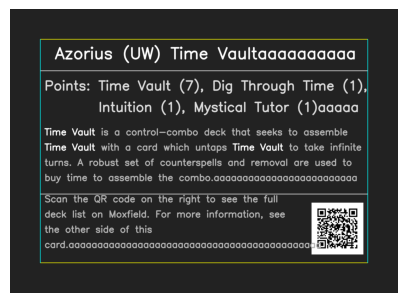

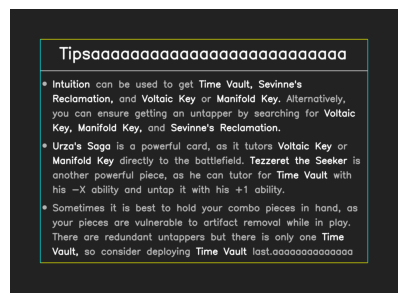

In [11]:
test_img_front = create_blank_image()
test_img_back = create_blank_image()

font = cv2.FONT_HERSHEY_SIMPLEX

title_font_size = 6
title_font_width = math.ceil(title_font_size * 3)
title_font_color = (255, 255, 255)
title_line_spacing = 1.2

points_font_size = 5
points_font_width = math.ceil(points_font_size * 3)
points_font_color = (220, 220, 220)
points_line_spacing = 1.2

summary_font_size = 3.5
summary_font_width = math.ceil(summary_font_size * 3)
summary_font_color = (180, 180, 180)
summary_line_spacing = 1.2

qr_font_size = 3.5
qr_font_width = math.ceil(qr_font_size * 3)
qr_font_color = (180, 180, 180)
qr_line_spacing = 1.2

back_title_font_size = 6
back_title_font_width = math.ceil(back_title_font_size * 3)
back_title_font_color = (255, 255, 255)
back_title_line_spacing = 1.2

back_text_font_size = 3.5
back_text_font_width = math.ceil(back_text_font_size * 3)
back_text_font_color = (180, 180, 180)
back_text_line_spacing = 1.1

qr_size = (600, 600)
qr_offset = 75
top_margin = 400
bot_margin = 400
left_margin = 400
right_margin = 400
line_break_spacing = 35

bold_words = ["Time Vault", "Intuition", "Sevinne's Reclamation", "Voltaic Key", "Manifold Key",
              "Urza's Saga", "Tezzeret the Seeker"]

summary_text = TextBox(
    "Summary Text",
    "Time Vault is a control-combo deck that seeks to assemble Time Vault with a card which untaps Time Vault to take infinite turns. A robust set of counterspells and removal are used to buy time to assemble the combo.aaaaaaaaaaaaaaaaaaaaaaaaa",
    font,
    summary_font_size,
    summary_font_width,
    summary_font_color,
    left_margin,
    right_margin,
    summary_line_spacing,
    bold_words = bold_words,
)
summary_text.calculate_text_bb(test_img_front, 800, 2.5)

qr_image = cv2.resize(cv2.imread("images/uw_vault_control_qr.png"), qr_size)

qr_text = TextBox(
    "QR Text",
    "Scan the QR code on the right to see the full deck list on Moxfield. For more information, see the other side of this card.aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa",
    font,
    summary_text.font_scale,
    summary_text.font_width,
#     qr_font_size,
#     qr_font_width,
    qr_font_color,
    left_margin,
    right_margin + qr_offset + qr_image.shape[1],
    qr_line_spacing
)
qr_text.calculate_text_bb(test_img_front, 500, summary_text.font_scale)

points_prefix = TextBox(
    "Points Prefix",
    "Points: ",
    font,
    points_font_size,
    points_font_width,
    points_font_color,
    left_margin,
    right_margin,
    points_line_spacing
)
points_prefix.calculate_text_bb(test_img_front, 200, summary_text.font_scale + 0.5)

points_text = TextBox(
    "Points Text",
    "Time Vault (7); Dig Through Time (1); Intuition (1); Mystical Tutor (1)aaaaa",
    font,
    points_font_size,
    points_font_width,
    points_font_color,
    left_margin + points_prefix.width,
    right_margin,
    points_line_spacing,
    delim = ';',
    splitter = ','
)
points_text.calculate_text_bb(test_img_front, 600, summary_text.font_scale + 0.5)

if(points_text.font_scale < points_prefix.font_scale):
    points_prefix.font_scale = points_text.font_scale
    points_prefix.font_width = points_text.font_width
    points_prefix.calculate_text_bb(test_img_front, 200, points_text.font_scale)
    points_text.calculate_text_bb(test_img_front, 550, points_text.font_scale)

title_text = TextBox(
    "Front Title",
    "Azorius (UW) Time Vaultaaaaaaaaaa",
    font,
    title_font_size,
    title_font_width,
    title_font_color,
    left_margin,
    right_margin,
    title_line_spacing
)
title_text.calculate_text_bb(test_img_front, 280, points_text.font_scale + 0.5)


back_text = TextBox(
    "Back Body Text",
    "Intuition can be used to get Time Vault, Sevinne's Reclamation, and Voltaic Key or Manifold Key. Alternatively, you can ensure getting an untapper by searching for Voltaic Key, Manifold Key, and Sevinne's Reclamation.\pUrza's Saga is a powerful card, as it tutors Voltaic Key or Manifold Key directly to the battlefield. Tezzeret the Seeker is another powerful piece, as he can tutor for Time Vault with his -X ability and untap it with his +1 ability.\pSometimes it is best to hold your combo pieces in hand, as your pieces are vulnerable to artifact removal while in play. There are redundant untappers but there is only one Time Vault, so consider deploying Time Vault last.aaaaaaaaaaaaaa",
    font,
    back_text_font_size,
    back_text_font_width,
    back_text_font_color,
    left_margin,
    right_margin,
    back_text_line_spacing,
    bold_words = bold_words,
    paragraph_break = True
)
back_text.calculate_text_bb(test_img_back, 2200, 2.5)

back_title_text = TextBox(
    "Back Title Text",
    "Tipsaaaaaaaaaaaaaaaaaaaaaaaaaa",
    font,
    back_title_font_size,
    back_title_font_width,
    back_title_font_color,
    left_margin,
    right_margin,
    back_title_line_spacing
)
back_title_text.calculate_text_bb(test_img_back, 280, back_text.font_scale + 1)



front_vertical_space = calculate_vertical_space([title_text, points_text, summary_text],
                                                qr_height = qr_image.shape[0],
                                                top_margin = top_margin, bot_margin = bot_margin,
                                                line_break_spacing = line_break_spacing, num_line_breaks = 2,
                                                padding = 100)

back_vertical_space = calculate_vertical_space([back_title_text],
                                               padding = int(back_text.line_height + back_text.height),
                                               top_margin = top_margin, bot_margin = bot_margin,
                                               line_break_spacing = line_break_spacing, num_line_breaks = 1)

if (test_img_front.shape[0] - front_vertical_space) >= 0:
    
    title_Y = title_text.place_text(test_img_front, left_margin,
                                    top_margin + title_text.line_height,
                                    centered = True)
    
    place_line(test_img_front, left_margin - 50, test_img_front.shape[1] - right_margin + 50,
               title_Y - line_break_spacing, title_Y - line_break_spacing)

    points_prefix_Y = points_prefix.place_text(test_img_front, left_margin,
                                               title_Y + points_prefix.line_height + line_break_spacing)
    
    points_Y = points_text.place_text(test_img_front, left_margin + points_prefix.width,
                                      title_Y + points_text.line_height + line_break_spacing)
    
    summary_Y = summary_text.place_text(test_img_front, left_margin,
                                        points_Y + summary_text.line_height,
                                        bold = True)
    
    place_line(test_img_front, left_margin - 50, test_img_front.shape[1] - right_margin + 50,
               summary_Y + line_break_spacing, summary_Y + line_break_spacing)
    
    qr_coords = place_qr(test_img_front, qr_image,
                         test_img_front.shape[1] - right_margin - qr_image.shape[1],
                         summary_Y + line_break_spacing)
    
    qr_Y = qr_text.place_text(test_img_front, left_margin, qr_coords[1] - qr_text.bounding_box[1]\
                              + int((qr_text.bounding_box[1] - qr_text.height) / 2))
    
else:
    print("Front text uses too much vertical space.")

if (test_img_back.shape[0] - back_vertical_space) >= 0:
    back_title_Y = back_title_text.place_text(test_img_back, left_margin,
                                              top_margin + back_title_text.line_height,
                                              centered = True)

    place_line(test_img_back, left_margin - 50, test_img_front.shape[1] - right_margin + 50,
               back_title_Y - line_break_spacing, back_title_Y - line_break_spacing)

    back_text_Y = back_text.place_text(test_img_back, left_margin,
                                       back_title_Y + back_text.line_height + line_break_spacing,
                                       bold = True)
else:
    print("Back text uses too much vertical space.")

# Show margins
show_margins(test_img_front, left_margin - 50, top_margin - 50)
show_margins(test_img_back, left_margin - 50, top_margin - 50)

display_image(test_img_front)
display_image(test_img_back)